# Pipeline Improvements

In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
from itertools import combinations
from helpers.features import read_offset_csv, transform_offsets_to_paths, show_image, precision_and_recall, timeit
from math import ceil
import operator
import time

## Dataset representation

Creating a representation where the combinations of all books (in pairs of two) are matched.

Furthermore, for every page we need to compare not only page *x* with page *x* of the two books but also other pages for getting information about false positives. For this we take an offset of 0.05 in every direction, comparing page x with all pages in range *x·0.975* to *x·1.25*.

In [2]:
shuuchin1 = read_offset_csv("annotations/shuuchinbukan-1.csv")
shuuchin1_paths = transform_offsets_to_paths(shuuchin1)

In [3]:
def build_page_index(offset_df):
    index = []
    for book1_id, book2_id in combinations(offset_df.columns, 2):
        for page in offset_df.index:
            index.append((book1_id, book2_id, page))
    return pd.MultiIndex.from_tuples(index, names=("Book1", "Book2", "Page"))

def build_page_df(offset_df, radius_factor=0.025):
    """
    Build a DataFrame where each row is a Book1, Book2, Book1-Page combination.
    Each column is an offset, specifying the the corresponding Book2-Page
    for later comparison. If this is 0, then no corresponding page exists.
    """
    index = build_page_index(offset_df)
    nr_pages = offset_df.index.size
    def handle_borders(n):
        if n < 0:
            return 0
        elif n > nr_pages:
            return 0
        else:
            return n
    radius = ceil(nr_pages * radius_factor)
    diameter = radius * 2 + 1
    page_array = np.empty((len(index), diameter), dtype=np.int32)
    for i, (_, _, page) in enumerate(index):
        first_page = page - radius
        last_page = page + radius
        pages = np.fromiter((handle_borders(p) for p in range(first_page, last_page + 1)),
                            count=diameter, dtype=np.int32)
        page_array[i,:] = pages
    columns = pd.RangeIndex(-radius, radius+1)
    return pd.DataFrame(page_array, index=index, columns=columns)

In [4]:
page_df = build_page_df(shuuchin1)

## Pipeline

1. Read image
2. Preprocessing
3. Detect keypoints
4. Extract descriptors
5. Match descriptors
6. Filter matches
7. Select keypoints
8. Find homography

### Read image, detect keypoints, extract descriptors

This might also include preprocessing (currently just some static cropping).

In [5]:
def crop_image(img, horizontal_factor=0.1, vertical_factor=0.15):
    height, width = img.shape
    return img[int(height * vertical_factor) : int(height - height * vertical_factor),
               int(width * horizontal_factor): int(width - width * horizontal_factor)]

def read_image(path):
    img = cv.imread(path, flags=cv.IMREAD_REDUCED_GRAYSCALE_4)
    img = crop_image(img)
    return img

@timeit
def detect_and_extract(path_df, detector):
    def process_path(path):
        if not path:
            return [np.nan, np.nan]
        else:
            return detector.detectAndCompute(read_image(path), None)
    keypoints = path_df.applymap(process_path)
    descriptors = keypoints.applymap(operator.itemgetter(1))
    keypoints = keypoints.applymap(operator.itemgetter(0))
    return keypoints, descriptors

In [6]:
detector = cv.AKAZE_create(cv.AKAZE_DESCRIPTOR_MLDB_UPRIGHT, descriptor_size=0, threshold=0.005)
detect_time_s, (keypoints, descriptors) = detect_and_extract(shuuchin1_paths, detector)
print("Detection and extraction took", detect_time_s, "seconds.")

Detection and extraction took 264.2820000000065 seconds.


### Descriptor matching

In [7]:
@timeit
def find_matches(page_df, descriptors, matcher):
    def process_series(series):
        book1, book2, page_book1 = series.name
        desc_book1 = descriptors[book1][page_book1]
        best_matches = np.empty_like(series.values, dtype=np.object)
        next_matches = np.empty_like(series.values, dtype=np.object)
        for i, page_book2 in enumerate(series):
            if page_book2 == 0:
                best_matches[i] = np.nan
                next_matches[i] = np.nan
            else:
                desc_book2 = descriptors[book2][page_book2]
                if isinstance(desc_book1, np.ndarray) and isinstance(desc_book2, np.ndarray):
                    match_pairs = matcher.knnMatch(desc_book1, desc_book2, 2)
                    first, second = zip(*match_pairs)
                    best_matches[i] = first
                    next_matches[i] = second
                else:
                    best_matches[i] = np.nan
                    next_matches[i] = np.nan
        return list(zip(best_matches, next_matches))
    return page_df.transform(process_series, axis=1)

In [8]:
matcher = cv.BFMatcher_create(normType=cv.NORM_HAMMING)
match_time_s, match_pairs_df = find_matches(page_df, descriptors, matcher)
print("Matching took", match_time_s, "seconds.")

Matching took 129.09299999999348 seconds.


In [217]:
distance_threshold = 100
nr_best_matches_df = (match_pairs_df
                      .applymap(operator.itemgetter(0))
                      .applymap(lambda x: len(
                          [m for m in x if m.distance < distance_threshold]
                      ) if isinstance(x, tuple) else np.nan))

### Filtering matches

In [9]:
@timeit
def filter_match_pairs(match_pairs_df, difference_threshold=10, distance_threshold=100):
    def optimal_match(match_pair):
        first_matches, second_matches = match_pair
        if not isinstance(first_matches, tuple) or not isinstance(second_matches, tuple):
            return np.nan
        else:
            matches = [a for a, b in zip(first_matches, second_matches)
                       if abs(a.distance - b.distance) > difference_threshold
                       and a.distance < distance_threshold]
            return matches
    return match_pairs_df.applymap(optimal_match)

In [10]:
filter_time_s, matches_df = filter_match_pairs(match_pairs_df)
print("Filtering match pairs took", filter_time_s, "seconds.")

Filtering match pairs took 7.733999999938533 seconds.


In [182]:
nr_matches_df = matches_df.applymap(lambda x: len(x) if isinstance(x, list) else np.nan)

### Select keypoints

In [11]:
@timeit
def select_keypoints(page_df, matches_df, keypoints):
    def matches_to_keypoints(series):
        book1, book2, page_book1 = series.name
        keypoints_array = np.empty_like(series.values, dtype=np.object)
        for i, (page_offset, page_book2) in enumerate(series.items()):
            matches = matches_df.loc[series.name, page_offset]
            if not isinstance(matches, list):
                keypoints_array[i] = np.nan
            else:
                points1 = np.empty((len(matches), 2), dtype=np.float32)
                for j, point in enumerate(keypoints[book1][page_book1][match.queryIdx].pt
                                          for match in matches):
                    points1[j,:] = point
                points2 = np.empty((len(matches), 2), dtype=np.float32)
                for j, point in enumerate(keypoints[book2][page_book2][match.trainIdx].pt
                                          for match in matches):
                    points2[j,:] = point
                keypoints_array[i] = (points1, points2)
        return keypoints_array
    return page_df.transform(matches_to_keypoints, axis=1)

In [12]:
kpfilter_time_s, filtered_keypoints_df = select_keypoints(page_df, matches_df, keypoints)
print("Filtering out keypoints took", kpfilter_time_s, "seconds.")

Filtering out keypoints took 131.0779999999795 seconds.


### Find homography

In [45]:
@timeit
def compute_homography_and_mask(selected_keypoints):
    def find_homography(keypoints):
        if isinstance(keypoints, tuple):
            points1, points2 = keypoints
            if (points1.size == 0) and (points2.size == 0):
                na_homography = np.full((3, 3), np.nan, dtype=np.float64)
                empty_mask = np.empty((0, 1), dtype=np.uint8)
                return (na_homography, empty_mask)
            else:
                return cv.findHomography(points1, points2, cv.RANSAC)
        else:
            return (np.nan, np.nan)
    results = selected_keypoints.applymap(find_homography)
    homographies = results.applymap(operator.itemgetter(0))
    masks = results.applymap(operator.itemgetter(1))
    return homographies, masks

In [46]:
homography_time_s, (homography_df, hmask_df) = compute_homography_and_mask(filtered_keypoints_df)
print("Calculating homographies took", homography_time_s, "seconds.")

Calculating homographies took 2473.5629999999655 seconds.


In [177]:
hmask_sum_df = hmask_df.applymap(lambda x: x.sum() if isinstance(x, np.ndarray) else np.nan)

## Metrics

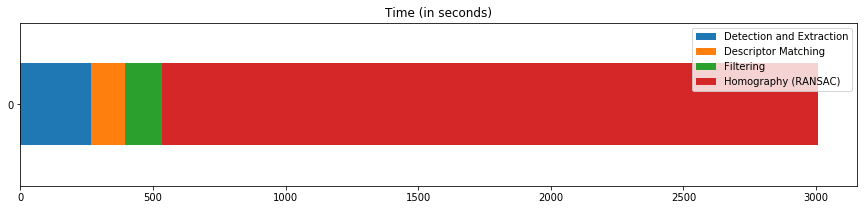

In [207]:
total_time_s = pd.DataFrame([detect_time_s, match_time_s, filter_time_s + kpfilter_time_s, homography_time_s],
                            index=["Detection and Extraction", "Descriptor Matching", "Filtering", "Homography (RANSAC)"])
total_time_s.T.plot.barh(stacked=True, figsize=(15, 3), title="Time (in seconds)")

In [179]:
def calculate_metrics(result_df, thresholds):
    positives = result_df[0].dropna()
    nr_positives = positives.size
    negatives = result_df.drop(0, axis=1).stack()
    metrics = np.empty((len(thresholds), 3), dtype=np.float64)
    for i, threshold in enumerate(thresholds):
        nr_true_positives = (positives > threshold).sum()
        nr_false_positives = (negatives > threshold).sum()
        precision = nr_true_positives / (nr_true_positives + nr_false_positives)
        recall = nr_true_positives / nr_positives
        f1 = (2 * precision * recall) / (precision + recall)
        metrics[i, 0] = precision
        metrics[i, 1] = recall
        metrics[i, 2] = f1
    return pd.DataFrame(metrics, columns=["Precision", "Recall", "F1"], index=thresholds)

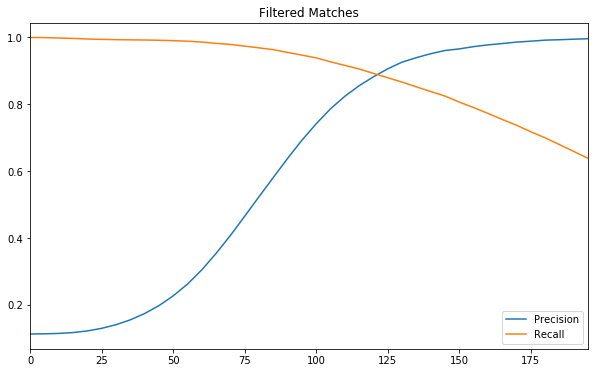

In [237]:
best_matches_thresholds = thresholds = np.arange(0, 200, 5)
best_matches_metrics = calculate_metrics(nr_best_matches_df, best_matches_thresholds)
best_matches_metrics.drop("F1", axis=1).plot(figsize=(10, 6), title="Filtered Matches")

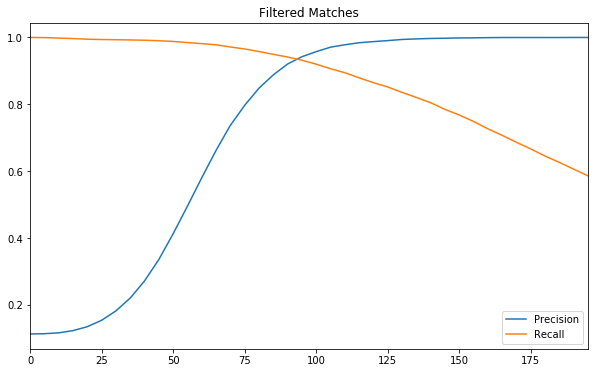

In [236]:
matches_thresholds = thresholds = np.arange(0, 200, 5)
matches_metrics = calculate_metrics(nr_matches_df, matches_thresholds)
matches_metrics.drop("F1", axis=1).plot(figsize=(10, 6), title="Filtered Matches")

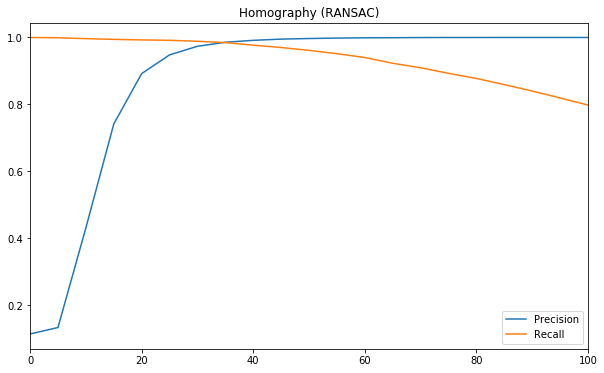

In [235]:
hmask_thresholds = thresholds = np.arange(0, 200, 5)
hmask_metrics = calculate_metrics(hmask_sum_df, hmask_thresholds)
hmask_metrics.drop("F1", axis=1).loc[:100].plot(figsize=(10, 6), title="Homography (RANSAC)")

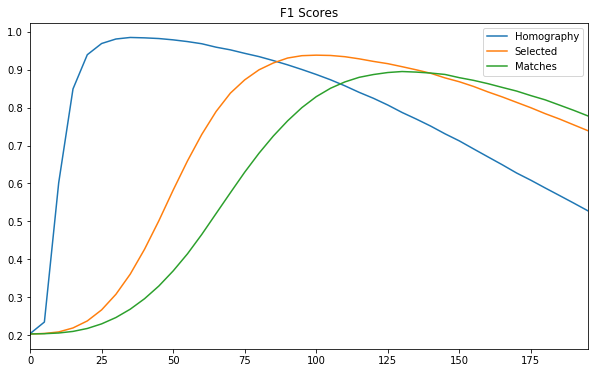

In [245]:
f1_scores = pd.concat([hmask_metrics["F1"], matches_metrics["F1"], best_matches_metrics["F1"]], axis=1)
f1_scores.columns = ["Homography", "Selected", "Matches"]
f1_scores.plot(figsize=(10, 6), title="F1 Scores")

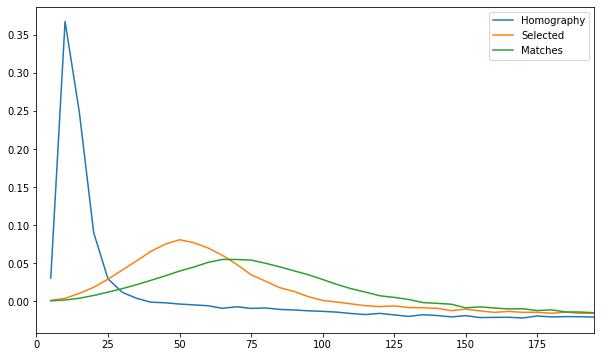

In [249]:
f1_scores.diff().plot(figsize=(10, 6))